In [1]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import matplotlib as mpl
from scipy import interpolate
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import rcParams
from captum.attr import GradientShap
from scipy.signal import savgol_filter
from matplotlib.ticker import MultipleLocator
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from utils import *
from qs_vae import *
from utils_features import *
from utils_attributions import *
from utils_cleaning import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.seterr(divide='ignore', invalid='ignore');
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

#### Content  
In this notebook we try to optimize the attribution calculations in order to process the entire PF database in a reasonable time. We use a set of deeply trained networks over 100 epochs and select the best models that when comparing to the results of the full stack, best reflect the heatmaps. We select 9 optimal models instead of using the full 50 ensemble, which reduces the processing time from 30 days to 5 days. Incomplete script, used to measure outcomes based on several targets.

In [2]:
import time

def number_of_days(time, data):
    '''
    time in seconds --> number of days to process entire dataset
    this is an overestimation since more ops are involved
    '''
    total_number_spec = 2352972
    specs_for_this_spectrogram = data.shape[1]
    t_per_spec = time / specs_for_this_spectrogram
    
    total_time = ((total_number_spec * t_per_spec) / (60 * 60)) / 24
    total_time = np.round( total_time, 2 )
    
    return f'processing time for entire PF dataset: {total_time} days'

#### Count the total number of spectra over the entire dataset

In [4]:
count = 1
total_spec = 0
path_to_raw_data = '/data1/iris_level_2C_10DNs/'
for obs in os.listdir(path_to_raw_data):
    if 'PF' not in obs: continue
    fhand = np.load(f'{path_to_raw_data}{obs}')
    data = fhand['data']
    shape = data.shape[:-1]
    n_spec = shape[0]*shape[1]*shape[2]
    total_spec += n_spec
    count += 1
print(f'number of flares: {count}')
print(f'number of spectra: {total_spec}')

number of flares: 20
number of spectra: 2352972


In [5]:
count = 1
total_spec = 0
path_to_raw_data = '/data1/iris_level_2C_10DNs/'
for obs in os.listdir(path_to_raw_data):
    if 'AR' not in obs: continue
    fhand = np.load(f'{path_to_raw_data}{obs}')
    data = fhand['data']
    shape = data.shape[:-1]
    n_spec = shape[0]*shape[1]*shape[2]
    total_spec += n_spec
    count += 1
print(f'number of active regions: {count}')
print(f'number of spectra: {total_spec}')

number of active regions: 19
number of spectra: 2633950


#### Sample of spectra to test with the full and reduced model swarm 

In [10]:
# # obs 1
# obs = 'PF_20140612_110933_3863605329'
# step = 5 # raster step
# y_pix = 64 # pixel choice for the spectrogram
# spec_ind = 58 # index of spectrum to plot from the spectrogram

# # obs 2
# obs = 'PF_20140612_110933_3863605329'
# step = 7 # raster step
# y_pix = 56 # pixel choice for the spectrogram
# spec_ind = 24 # index of spectrum to plot from the spectrogram

# obs 3
obs = 'FL_20140910_112825_3860259453'
step = 0 # raster step
y_pix = 400 # pixel choice for the spectrogram
spec_ind = 195 # index of spectrum to plot from the spectrogram

# # obs 4
# obs = 'PF_20140212_215458_3860257280'
# step = 7 # raster step
# y_pix = 519 # pixel choice for the spectrogram
# spec_ind = 13 # index of spectrum to plot from the spectrogram

In [14]:
fhand = np.load(f'/data1/iris_level_2C_10DNs/{obs}.npz', allow_pickle=True)
data = fhand['data']
nprof_slice = data[step,:,y_pix,:]

In [15]:
fold = 44 # model corresponding to a particular test/train split of the observations
degree_of_smooth = 41 # post-hoc smooth of attributions
baseline_samples = 500 # number of background data used to calculate attributions

In [16]:
with open(f'/data1/userspace/bpanos/XAI/models/ConvNet/{fold}.p', 'rb') as f: dic = pickle.load(f)
path_to_clean_data = '/data1/userspace/bpanos/XAI/data/ConvNet/clean_strong/'
train_obs = dic['train_obs']
AR_train = []
PF_train = []
for n in train_obs:
    if 'AR' in n:
        AR_train.append(n)
    if 'PF' in n:
        PF_train.append(n)
X_train_AR = None
X_train_PF = None
for AR_file, PF_file in zip(AR_train, PF_train):
    fhand = np.load(path_to_clean_data + AR_file)
    X_AR = fhand['X']
    try: X_train_AR = np.concatenate( (X_train_AR, X_AR), axis=0 )
    except: X_train_AR = X_AR
    fhand = np.load(path_to_clean_data + PF_file)
    X_PF = fhand['X']
    try: X_train_PF = np.concatenate( (X_train_PF, X_PF), axis=0 )
    except: X_train_PF = X_PF
X_train_AR, X_train_PF = Balance(X_train_AR, X_train_PF)
y_train_AR = np.zeros(len(X_train_AR))
y_train_PF = np.ones(len(X_train_PF))
X_train = np.concatenate((X_train_AR, X_train_PF), axis=0)
y_train = np.concatenate((y_train_AR, y_train_PF))
baseline = torch.Tensor(X_train).to(device).unsqueeze(1)

In [17]:
path_to_models = '/data1/userspace/bpanos/XAI/models/EG/'
model_paths = [ f'{path_to_models}{name}' for name in os.listdir(path_to_models) ]
model_paths

['/data1/userspace/bpanos/XAI/models/EG/5_val.pt',
 '/data1/userspace/bpanos/XAI/models/EG/9_val.pt',
 '/data1/userspace/bpanos/XAI/models/EG/1_val.pt',
 '/data1/userspace/bpanos/XAI/models/EG/8_val.pt',
 '/data1/userspace/bpanos/XAI/models/EG/3_val.pt',
 '/data1/userspace/bpanos/XAI/models/EG/2_val.pt',
 '/data1/userspace/bpanos/XAI/models/EG/6_val.pt',
 '/data1/userspace/bpanos/XAI/models/EG/4_val.pt',
 '/data1/userspace/bpanos/XAI/models/EG/7_val.pt']

In [20]:
start = time.time()
heatmaps = []
y_raws = []
for spectrum in tqdm(nprof_slice):
    heatmap = []
    y_raw = []
    for path in model_paths:
        model = CNN(num_classes=2)
        model.load_state_dict(torch.load(path))
        model.to(device)
        model.eval();
        # attributions of single spectrum are calculated here
        y, y_hat, heat = EG_attributions(spectrum, baseline, model, n_samples=baseline_samples, degree_of_smooth=degree_of_smooth)
        heatmap.append(heat)
        y_raw.append(y)
        del model
    heatmap = np.vstack(heatmap)
    heatmap = np.nanmean(heatmap, axis=0)
    heatmaps.append(heatmap)
    y_raws.append(np.nanmean(y_raw))
heatmap = np.flip(np.transpose(heatmaps),0)
heatmap = np.flip(heatmap,0)
y_raw = y_raws/np.nanmax(y_raws)
y_raw = torch.Tensor(y_raw)
y_raw = y_raw.expand(data.shape[3],-1)
y_raw = y_raw.numpy()
end = time.time()
ts = end - start
number_of_days(ts, data)

100%|██████████| 237/237 [00:47<00:00,  5.35it/s]


'processing time for entire PF dataset: 5.43 days'

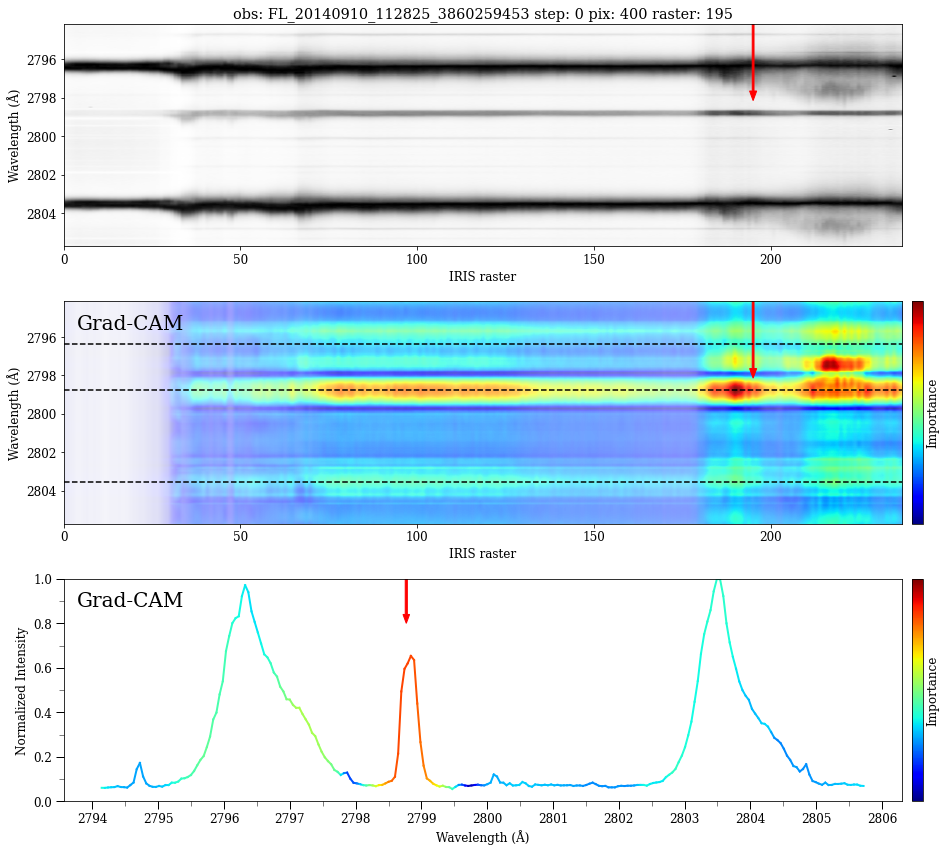

In [21]:
plot_shap_spectrogram(nprof_slice, heatmap, y_raw,
                      method='Grad-CAM',
                      fold=44,
                      obs=obs,
                      pix=y_pix,
                      spec_ind=spec_ind)

### End